In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torch import nn
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from models.kaggle_dog_dataloader import *
from models.SwaV import SwaV
from models.SupervisedDownstream import SupervisedDownstream
from active_learning_data import Data

In [3]:
data_dir = "../../../user_data/competition_data/clips"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

targets = [
    'Dog_1',
    'Dog_2',
    'Dog_3',
    'Dog_4',
]

# targets = [
#     'Patient_1',
#     'Patient_2',
#     'Patient_3',
#     'Patient_4',
#     'Patient_5',
#     'Patient_6',
#     'Patient_7',
#     'Patient_8'
# ]

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
determine_generator = torch.Generator()
determine_generator.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [5]:
strategy_name = 'VarRatio'

In [6]:
args_task = {'n_epoch': 100,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 256, 'num_workers': 0, 'collate_fn': collate_fn,
                                'drop_last': True},
             'loader_te_args': {'batch_size': 256, 'num_workers': 0, 'collate_fn': collate_fn,
                                'drop_last': True}
             }

In [7]:
data, label = load_annotated_data(data_dir, targets)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.30, random_state=random_seed)

Loading data
(0s)
X (178, 16, 400) y (178,) latencies (178,)
Loading data
(0s)
X (172, 16, 400) y (172,) latencies (172,)
Loading data
(0s)
X (480, 16, 400) y (480,) latencies (480,)
Loading data
(0s)
X (257, 16, 400) y (257,) latencies (257,)
Loading data
(0s)
X (418, 16, 400) y (418,)
Loading data
(0s)
X (1148, 16, 400) y (1148,)
Loading data
(3s)
X (4760, 16, 400) y (4760,)
Loading data
(2s)
X (2790, 16, 400) y (2790,)
(10203, 16, 400)


In [8]:
dataset = Data(X_train, y_train, X_test, y_test, ActiveDataHandler, args_task)

TypeError: Data.__init__() missing 2 required positional arguments: 'handler' and 'args_task'

In [22]:
test_data = dataset.get_test_data()

In [23]:
test_data.Y.shape

(3061, 1)

In [24]:
# swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_18/kaggle_dog_swav-epoch=116-swav_loss=2.23095.ckpt')
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'kaggle_dog_swav_34/kaggle_dog_swav-epoch=116-swav_loss=2.73583.ckpt')
# swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_50/kaggle_dog_swav-epoch=118-swav_loss=3.64062.ckpt')
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',
                                                   filename='kaggle_dog_linear_eval-{epoch:02d}-{val_loss:.5f}',
                                                   save_last=True, save_top_k=-1,
                                                   dirpath=ckpt_folder_root + 'kaggle_dog_swav_34_linear_eval_3c')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name="kaggle_dog_swav_34_linear_eval_3c")

trainer = pl.Trainer(logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback], accelerator='gpu', devices=1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

val_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)
predictions = trainer.predict(model, val_dataloader,ckpt_path=ckpt_folder_root + 'kaggle_dog_active/active_checkpoints_EntropySampling/EntropySampling_round_12-epoch=99-train_loss=0.25522.ckpt')

Restoring states from the checkpoint path at ../../../user_data/checkpoints/kaggle_dog_active/active_checkpoints_EntropySampling/EntropySampling_round_12-epoch=99-train_loss=0.25522.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../../user_data/checkpoints/kaggle_dog_active/active_checkpoints_EntropySampling/EntropySampling_round_12-epoch=99-train_loss=0.25522.ckpt
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [30]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(target)

tensor([[-1.4234,  1.4006, -0.0382,  0.3646, -1.9584],
        [-0.6761, -0.5008, -1.2458, -0.4481, -0.1537],
        [-1.9868, -0.0352, -1.0558, -0.3352, -0.5795]], requires_grad=True)
tensor([3, 2, 2])


In [17]:
labeled_dataset = KaggleDataset(data_X, data_y, test_data_X, labeled=True, transform=False)
train_set_size = int(labeled_dataset.length * 0.8)
valid_set_size = labeled_dataset.length - train_set_size
train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size],
                                                    generator=torch.Generator().manual_seed(42))
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)
predictions = trainer.predict(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 3it [00:00, ?it/s]

In [42]:
train_set

In [26]:
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

In [27]:
pred_raw = torch.vstack(output_list)
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [28]:
def translate_prediction(prediction, y_classes):
    if len(prediction) == 3:
        # S is 1.0 when ictal <=15 or >15
        # S is 0.0 when interictal is highest
        ictalLTE15, ictalGT15, interictal = prediction
        S = ictalLTE15 + ictalGT15
        E = ictalLTE15
        return S, E
    elif len(prediction) == 2:
        # 1.0 doesn't exist for Patient_4, i.e. there is no late seizure data
        if not np.any(y_classes == 1.0):
            ictalLTE15, interictal = prediction
            S = ictalLTE15
            E = ictalLTE15
            # y[i] = 0 # ictal <= 15
            # y[i] = 1 # ictal > 15
            # y[i] = 2 # interictal
            return S, E
        else:
            raise NotImplementedError()
    else:
        raise NotImplementedError()


# use the classifier and make predictions on the test data
def make_predictions(target, X_test, y_classes, classifier_data):
    classifier = classifier_data.classifier
    predictions_proba = classifier.predict_proba(X_test)

    lines = []
    for i in range(len(predictions_proba)):
        p = predictions_proba[i]
        S, E = translate_prediction(p, y_classes)
        lines.append('%s_test_segment_%d.mat,%.15f,%.15f' % (target, i+1, S, E))

    return {
        'data': '\n'.join(lines)
    }


# the scoring mechanism used by the competition leaderboard
def score_classifier_auc(classifier, X_cv, y_cv, y_classes):
    predictions = classifier.predict_proba(X_cv)
    S_predictions = []
    E_predictions = []
    S_y_cv = [1.0 if (x == 0.0 or x == 1.0) else 0.0 for x in y_cv]
    E_y_cv = [1.0 if x == 0.0 else 0.0 for x in y_cv]

    for i in range(len(predictions)):
        p = predictions[i]
        S, E = translate_prediction(p, y_classes)
        S_predictions.append(S)
        E_predictions.append(E)

    fpr, tpr, thresholds = roc_curve(S_y_cv, S_predictions)
    S_roc_auc = auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(E_y_cv, E_predictions)
    E_roc_auc = auc(fpr, tpr)

    return S_roc_auc, E_roc_auc

In [30]:
output = torch.vstack(output_list)
target = torch.vstack(target_list)
inds = np.where(target == 0)

S = output[:,0] + output[:,1]
E = output[:,0]
S_y_cv = [1.0 if (x == 0.0 or x == 1.0) else 0.0 for x in target]
E_y_cv = [1.0 if x == 0.0 else 0.0 for x in target]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(S_y_cv, S, pos_label=1)
S_roc_auc = sklearn.metrics.auc(fpr, tpr)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(E_y_cv, E, pos_label=1)
E_roc_auc = sklearn.metrics.auc(fpr, tpr)

In [35]:
E_roc_auc

0.9743014200641319

In [36]:
S_roc_auc

0.9932463250216544

In [31]:
(S_roc_auc+E_roc_auc)/2

0.9837738725428932

In [48]:
np.argmax(output,axis=1)

tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1,

In [40]:
len(torch.sort(m(output)[:, 0][inds])[0])

65

In [33]:
sklearn.metrics.accuracy_score(np.argmax(m(output), axis=1), target)

0.964390721986279

In [34]:
clf_report = sklearn.metrics.classification_report(np.argmax(m(output), axis=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.486486  0.771429  0.596685        70
           1   0.822314  0.812245  0.817248       245
           2   0.996677  0.982884  0.989732      2746

    accuracy                       0.964391      3061
   macro avg   0.768492  0.855519  0.801222      3061
weighted avg   0.971053  0.964391  0.966938      3061


In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [38]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)
#
tsne = TSNE(n_components=2, verbose=1, perplexity=75, random_state=142, init='pca')
z = tsne.fit_transform(emb)



C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 3061 samples in 0.000s...
[t-SNE] Computed neighbors for 3061 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3061
[t-SNE] Computed conditional probabilities for sample 2000 / 3061
[t-SNE] Computed conditional probabilities for sample 3000 / 3061
[t-SNE] Computed conditional probabilities for sample 3061 / 3061
[t-SNE] Mean sigma: 2.372910


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.087963
[t-SNE] KL divergence after 1000 iterations: 0.535448


In [41]:
ictal_pre_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]
interictal_inds = np.where(target == 2)[0]

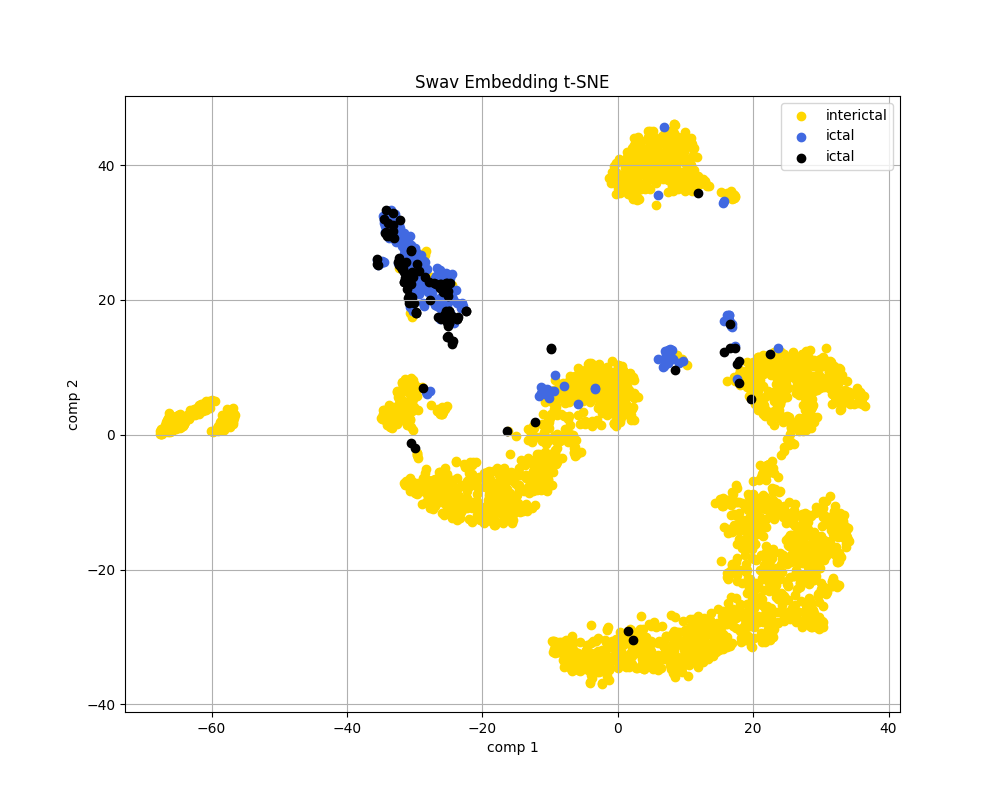

In [43]:
spc = z

plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1], c='royalblue', label='ictal')
plt.scatter(spc[ictal_pre_inds, 0], spc[ictal_pre_inds, 1], c='black', label='ictal')
plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2" )
plt.legend()
plt.grid()
plt.show()

In [50]:
from sklearn.metrics import RocCurveDisplay
target, np.argmax(output,axis=1)

RocCurveDisplay.from_predictions(
    target,
    np.argmax(output,axis=1),
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

ValueError: multiclass format is not supported

In [ ]:
output[:, 1]

In [ ]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target = target.squeeze().detach().cpu().numpy()

In [ ]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
for batch, label in tqdm(val_dataloader):
    batch = batch.to(device)
    label = label.to(device)
    label = F.one_hot(label).squeeze()
    outputs = model(batch)
    print(batch)
    loss = sigmoid_focal_loss(pred.float(), label.float(), alpha=0.5, gamma=8, reduction='mean')
    print(loss)
    break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")    